<h1><center>
    Eyetracking: Experiment Design and Machine Learning Methods<br/>
  
    
    Assignment 7
</center></h1>

Last week, we implemented a neural network with initialization from scratch. This week, we will work with Tensorflow to use a CNN.

In [481]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np

Please check that you're working with Tensorflow 2.x. You're also free to use pytorch or any other DL framework.

The assignment is structure in the following way: Load the data, explore the data, preprocess the data, define your network, train your network, evaluate your network.
This is basically a dress rehearsal for the second project. 

# Task 1

Load GazeBase dataset: https://figshare.com/articles/dataset/GazeBase_Data_Repository/12912257

You already know this dataset from the assignment 'getting to know the data', but to recap: there are up to 322 subjects, several different tasks and 9 rounds with two sessions for each task.

Decide for one subtask and state a problem-setting you want to investigate using a CNN. As in the exercise two weeks ago the results do not need to be above random guessing, it is only about the execution. NOTE: the dataset (subtask) you're using in this assignment is then excluded from the final project. But if you want to use another task of GazeBase and a CNN the pipeline should be easily adjustable.

## Load the data

In [303]:
import os
import glob
from zipfile import ZipFile
from pathlib import Path
import pandas as pd

In [304]:
target_participant = '016.zip', '043.zip', '063.zip', '128.zip', '152.zip', '180.zip', '192.zip', '196.zip', '207.zip', '215.zip', '216.zip', '259.zip', '288.zip', '314.zip'

target_task = 'BLG.csv'


In [305]:
file_name = "GazeBase_v2_0.zip"

In [306]:
with ZipFile(file_name, 'r') as zip:
    zipname = zip.namelist()
    for elem in zipname:
        if elem.endswith(target_participant):
            with ZipFile(f'GazeBase_v2_0/{elem}', 'r') as zip:
                csvname = zip.namelist()
                for file in csvname:
                    if file.endswith(target_task):
                        zip.extract(file, path = './GazeBase_ex07')           

In [307]:
path_1 = "./GazeBase_ex07/S1/S1_Balura_Game"
path_2 = "./GazeBase_ex07/S2/S2_Balura_Game"
files = glob.glob(os.path.join(path_1, '*.csv'))
files.extend(glob.glob(os.path.join(path_2, '*.csv')))

In [308]:
df_list =[]
stride = 1000
for file in files:
    f_name = file.split('/')[-1]
    df = pd.read_csv(file, encoding='utf-8', sep=',')
    df = df[['n', 'x', 'y']]
    df.insert(0, 'ID', [int(f_name.split('_')[1][1:]) for n in range(len(df))])
    df.insert(1, 'round', [int(f_name.split('_')[1][0]) for n in range(len(df))])
    df.insert(2, 'session', [f_name.split('_')[2] for n in range(len(df))])
    df = df.dropna()
    df = df.iloc[:(len(df)//stride)*stride]
    df.insert(1, 'stride', [(i//stride+1) for i in range(len(df))])
    
    df_list.append(df)
    
gz_df = pd.concat(df_list, ignore_index=True)

In [309]:
gz_df = gz_df.sort_values(by=['ID','round', 'session'], ignore_index=True)

In [310]:
gz_df

,ID,stride,round,session,n,x,y
0,16,1,1,S1,0,-8.878117,-6.593976
1,16,1,1,S1,1,-8.880986,-6.588160
2,16,1,1,S1,2,-8.880986,-6.582345
3,16,1,1,S1,3,-8.878117,-6.573621
4,16,1,1,S1,4,-8.878117,-6.570713
...,...,...,...,...,...,...,...
7681995,314,19,9,S2,20645,14.297587,-15.160996
7681996,314,19,9,S2,20646,14.289307,-15.158251
7681997,314,19,9,S2,20647,14.289307,-15.158251
7681998,314,19,9,S2,20648,14.286546,-15.160996


In [212]:
## to try 'pathlib.Path'out.

# data_list = []
# for i in [1,2]:
#     paths = Path(f'./GazeBase_ex07/S{i}/S{i}_Balura_Game').glob('*.csv')
#     for path in paths:
#         single_data = pd.read_csv(path, encoding='utf-8', sep=',')
#         single_data = single_data[['n', 'x', 'y']]
#         single_data.insert(0, 'ID', [path.stem.split('_')[1][1:] for n in range(len(single_data))])
#         data_list.append(single_data)
#     data = pd.concat(data_list, ignore_index=True)

In [213]:
# data

# Task 2

State your problem setting below. Describe at least which architecture you are using, what its goal is, the format of the input data and labels and from where you got the data. For an example problem setting see e.g. [Jäger et al](https://arxiv.org/pdf/1906.11889.pdf).

### problem setting

### Architecture

# Task 3

Do basic data exploration (e.g. checking for nans, visualization, units and range of the data,...)

It would make sense to first extract the data from the files and store it in a suitable format for further processing, e.g. in a feature matrix and a label vector

In [265]:
gz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7682000 entries, 0 to 7681999
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   ID       int64  
 1   stride   int64  
 2   round    int64  
 3   session  object 
 4   n        int64  
 5   x        float64
 6   y        float64
dtypes: float64(2), int64(4), object(1)
memory usage: 410.3+ MB


In [266]:
gz_df.describe()  # these criterion are not very helpful.

,ID,stride,round,n,x,y
count,7.682000e+06,7.682000e+06,7.682000e+06,7.682000e+06,7.682000e+06,7.682000e+06
mean,1.828802e+02,2.105337e+01,4.688362e+00,2.159472e+04,-4.673639e-01,-3.347876e+00
std,8.357990e+01,1.948571e+01,2.662475e+00,2.103308e+04,1.234288e+01,7.642721e+00
min,1.600000e+01,1.000000e+00,1.000000e+00,0.000000e+00,-5.215016e+01,-4.051806e+01
25%,1.280000e+02,8.000000e+00,2.000000e+00,7.783000e+03,-1.079825e+01,-9.722981e+00
50%,1.960000e+02,1.600000e+01,5.000000e+00,1.585200e+04,-7.376980e-01,-3.272298e+00
75%,2.590000e+02,2.700000e+01,7.000000e+00,2.744600e+04,9.999258e+00,3.015376e+00
max,3.140000e+02,1.410000e+02,9.000000e+00,1.479230e+05,5.097592e+01,3.658586e+01


In [267]:
gz_df.isnull().sum()

ID         0
stride     0
round      0
session    0
n          0
x          0
y          0
dtype: int64

### Subset one participant in one round and one session to visualize the data.

In [273]:
sub_df = gz_df.loc[(gz_df['ID']==43) & (gz_df['round']==1) & (gz_df['session']=='S1')]

In [274]:
sub_df

,ID,stride,round,session,n,x,y
352000,43,1,1,S1,0,-3.906012,-4.155497
352001,43,1,1,S1,1,-3.911863,-4.149635
352002,43,1,1,S1,2,-3.917714,-4.146704
352003,43,1,1,S1,3,-3.914788,-4.149635
352004,43,1,1,S1,4,-3.914788,-4.155497
...,...,...,...,...,...,...,...
391995,43,40,1,S1,41192,-22.264926,-11.945529
391996,43,40,1,S1,41193,-22.257373,-11.939888
391997,43,40,1,S1,41194,-22.247303,-11.939888
391998,43,40,1,S1,41195,-22.237230,-11.942709


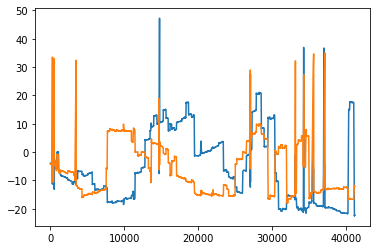

In [275]:
plt.plot(sub_df['n'], sub_df['x'])
plt.plot(sub_df['n'], sub_df['y'])

## Convert to numpy

In [505]:
x_np = gz_df['x'].to_numpy()
x_np = x_np.reshape(len(gz_df)//stride, stride)

In [506]:
x_np.shape, x_np

((7682, 1000),
 array([[ -8.878117,  -8.880986,  -8.880986, ...,  -1.68074 ,  -1.677803,
          -1.660183],
        [ -1.630815,  -1.601446,  -1.586762, ...,  12.13068 ,  12.125061,
          12.119442],
        [ 12.113822,  12.108202,  12.088532, ...,  14.631041,  14.625537,
          14.625537],
        ...,
        [ 19.232984,  19.248704,  19.240845, ..., -28.401845, -29.093182,
         -29.777573],
        [-30.45492 , -31.181101, -31.898429, ..., -18.321417, -18.324066,
         -18.329363],
        [-18.332012, -18.329363, -18.329363, ...,  14.289307,  14.286546,
          14.286546]]))

In [507]:
scaler = StandardScaler().fit(x_np)
x_scaled = scaler.transform(x_np)

In [508]:
x_scaled, x_scaled.shape

(array([[-0.66750182, -0.66811942, -0.6677723 , ..., -0.10982832,
         -0.11008227, -0.10850794],
        [-0.07639163, -0.07419069, -0.07247274, ...,  1.01086272,
          1.01041404,  1.00968393],
        [ 1.04465936,  1.04436267,  1.04360164, ...,  1.21374789,
          1.21339903,  1.21304905],
        ...,
        [ 1.6253181 ,  1.62694747,  1.6273195 , ..., -2.27804152,
         -2.33562264, -2.39018373],
        [-2.42736615, -2.48755844, -2.54628245, ..., -1.46009192,
         -1.46140155, -1.46118201],
        [-1.43858791, -1.43900091, -1.43887759, ...,  1.18601879,
          1.18588023,  1.18554054]]),
 (7682, 1000))

In [509]:
y_np = gz_df['y'].to_numpy()
y_np = y_np.reshape(len(gz_df)//stride, stride)

In [510]:
y_np.shape, y_np

((7682, 1000),
 array([[ -6.593976,  -6.58816 ,  -6.582345, ...,  -3.016712,  -2.996142,
          -3.004958],
        [ -3.013773,  -3.022589,  -3.028466, ...,  -2.775704,  -2.781584,
          -2.796282],
        [ -2.81098 ,  -2.816859,  -2.834496, ...,  -3.88574 ,  -3.888673,
          -3.88574 ],
        ...,
        [-13.077254, -13.353724, -13.442953, ...,   4.777987,   5.1231  ,
           5.470761],
        [  5.820934,   6.071625,   6.324994, ..., -10.736018, -10.736018,
         -10.736018],
        [-10.738862, -10.738862, -10.741707, ..., -15.158251, -15.160996,
         -15.139033]]))

In [511]:
scaler = StandardScaler().fit(y_np)
y_scaled = scaler.transform(y_np)

In [512]:
gz_X = np.stack((x_scaled, y_scaled),axis=2)
gz_X, gz_X.shape

(array([[[-0.66750182, -0.44089731],
         [-0.66811942, -0.43984243],
         [-0.6677723 , -0.43919974],
         ...,
         [-0.10982832,  0.04570891],
         [-0.11008227,  0.04842624],
         [-0.10850794,  0.04730752]],
 
        [[-0.07639163,  0.03129732],
         [-0.07419069,  0.03031226],
         [-0.07247274,  0.02938645],
         ...,
         [ 1.01086272,  0.07709291],
         [ 1.01041404,  0.07636753],
         [ 1.00968393,  0.07448514]],
 
        [[ 1.04465936,  0.05804379],
         [ 1.04436267,  0.05743973],
         [ 1.04360164,  0.05496178],
         ...,
         [ 1.21374789, -0.0674557 ],
         [ 1.21339903, -0.06780557],
         [ 1.21304905, -0.06740407]],
 
        ...,
 
        [[ 1.6253181 , -1.29597984],
         [ 1.62694747, -1.33194684],
         [ 1.6273195 , -1.34378488],
         ...,
         [-2.27804152,  1.06073268],
         [-2.33562264,  1.1057724 ],
         [-2.39018373,  1.15117116]],
 
        [[-2.42736615,  1.196

In [515]:
label = gz_df['ID'].to_numpy().reshape(len(gz_df)//stride, stride)

In [516]:
label, label.shape

(array([[ 16,  16,  16, ...,  16,  16,  16],
        [ 16,  16,  16, ...,  16,  16,  16],
        [ 16,  16,  16, ...,  16,  16,  16],
        ...,
        [314, 314, 314, ..., 314, 314, 314],
        [314, 314, 314, ..., 314, 314, 314],
        [314, 314, 314, ..., 314, 314, 314]]),
 (7682, 1000))

In [517]:
uni_label = list(np.unique(label))
uni_label

[16, 43, 63, 128, 152, 180, 192, 196, 207, 215, 216, 259, 288, 314]

In [518]:
uni_label.index(16)

0

In [519]:
t_cls = []
for elem in label:
    elem = [uni_label.index(elem[0])]*1000
    t_cls.append(elem)
t_cls = np.asarray(t_cls)

In [520]:
t_cls, t_cls.shape

(array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [13, 13, 13, ..., 13, 13, 13],
        [13, 13, 13, ..., 13, 13, 13],
        [13, 13, 13, ..., 13, 13, 13]]),
 (7682, 1000))

In [521]:
data = np.stack((x_scaled, y_scaled, t_cls),axis=2)

In [522]:
data.shape

(7682, 1000, 3)

## One-hot encoding the label

In [523]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [524]:
t_cls_ohe = ohe.fit_transform(gz_df[['ID']]).toarray()

In [525]:
t_cls_ohe, t_cls_ohe.shape

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 (7682000, 14))

In [526]:
t_cls_ohe = t_cls_ohe.reshape(7682, 1000, 14)
gz_Y = t_cls_ohe[:,0,:]

In [527]:
gz_Y, gz_Y.shape

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 (7682, 14))

## Shuffle the data

### * later I know that I do not need to do it manually here, Sklearn can do it for me.

In [528]:
np.random.shuffle(data)

In [529]:
Y = data[:,0,-1]

In [530]:
Y.shape

(7682,)

In [531]:
X = data[:,:,:2]

In [532]:
X.shape

(7682, 1000, 2)

In [533]:
X, Y 

(array([[[ 1.20474698, -1.05497759],
         [ 1.20518548, -1.05417198],
         [ 1.20607646, -1.05388708],
         ...,
         [ 0.13885942, -1.53678911],
         [ 0.09912489, -1.54434554],
         [ 0.06008087, -1.55481001]],
 
        [[-1.03857673, -0.25632993],
         [-1.03907844, -0.25724118],
         [-1.03951983, -0.25814632],
         ...,
         [ 1.50222386,  0.10197947],
         [ 1.50201974,  0.10355311],
         [ 1.50177721,  0.10550231]],
 
        [[-0.30893669,  1.08442077],
         [-0.30944433,  1.08435157],
         [-0.30923147,  1.08414037],
         ...,
         [-1.54765198, -1.29456122],
         [-1.54708728, -1.2956896 ],
         [-1.54534455, -1.29686527]],
 
        ...,
 
        [[-0.42401119,  1.13299313],
         [-0.4240799 ,  1.13368288],
         [-0.42318727,  1.13423914],
         ...,
         [ 0.46242784, -0.29303603],
         [ 0.46479215, -0.30669631],
         [ 0.46684933, -0.32075269]],
 
        [[-0.61898297, -0.149

# Task 4

Split the data into train and test split. We've already done something similar in assignment 5.
<br>
* Read in the unzipped files and store the data in a feature matrix and a label vector
* Do some data exploration on  both the features and the labels
* Preprocess the labels by one-hot-encoding
* You will need to reshape your feature matrix to work as an input for the CNN
* Pad the feature matrix
* Split the data into train and test sets



In [857]:
X_train, X_test, y_train, y_test = train_test_split(gz_X, gz_Y, test_size=0.10, random_state=42, shuffle=True) 

In [858]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6913, 1000, 2), (769, 1000, 2), (6913, 14), (769, 14))

# Task 5

Preprocess your data. This is not always necessary, however, note that using a full sequence as input can be very computationally intensive. This can be counteracted by downsampling or splitting. Splitting in this case means to only use a subsequence of the data, e.g., a few seconds, as input.

In [859]:
# I think I have done this step in the beginning.

# Task 6

Define your convolutional neural network.

Commonly used layers are:

In [860]:
# tf.keras.layers.Dropout(dropout_rate)
# tf.keras.layers.Conv1D(filters,kernel_size,strides=stride, activation=activation)
# tf.keras.layers.BatchNormalization()
# tf.keras.layers.Dense(units, activation=activation)
# tf.keras.layers.Softmax()
# tf.keras.layers.MaxPool1D(pool_size=pool_size, strides=stride)
# tf.keras.layers.AveragePooling1D(pool_size=pool_size, strides=stride)
# tf.keras.layers.GlobalAveragePooling1D()

In [890]:
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Conv1D(64, 7, activation='relu', input_shape=(1000,2)))
# model.add(layers.AveragePooling1D(pool_size=3, strides=2))

model.add(layers.Conv1D(32, 3, activation='relu'))
# model.add(layers.AveragePooling1D(pool_size=3, strides=2))

model.add(layers.Conv1D(16, 2, activation='relu'))
# model.add(layers.Conv1D(8, 2, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(14, activation='softmax'))


The simplest way to define a model is as a sequential model. In the list you stack the layers you want to use. Feel free to use other possibilities to define your model.

# Task 7

Compile your model. For that read the documentation on `model.compile(*args, **kwargs)`. You'll need at least an optimizer and a loss function.

In [891]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Task 8

Fit and test your model using `model.fit()` and `model.predict()`. If needed consult the documentation. Typically you provide the dataset, batch size, and number of epochs. You test your model on the test set defined above. 

In [892]:
verbose, epochs, batch_size = 0, 10, 32

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10


2022-05-19 13:10:12.337714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


217/217 [==============================] - 4s 17ms/step - loss: 2.5828 - accuracy: 0.1611
Epoch 2/10
217/217 [==============================] - 3s 16ms/step - loss: 2.5007 - accuracy: 0.1724
Epoch 3/10
217/217 [==============================] - 4s 16ms/step - loss: 2.4519 - accuracy: 0.1775
Epoch 4/10
217/217 [==============================] - 4s 16ms/step - loss: 2.4286 - accuracy: 0.1856
Epoch 5/10
217/217 [==============================] - 3s 16ms/step - loss: 2.4026 - accuracy: 0.1922
Epoch 6/10
217/217 [==============================] - 4s 16ms/step - loss: 2.3737 - accuracy: 0.1988
Epoch 7/10
217/217 [==============================] - 3s 16ms/step - loss: 2.3849 - accuracy: 0.1938
Epoch 8/10
217/217 [==============================] - 4s 16ms/step - loss: 2.3459 - accuracy: 0.2040
Epoch 9/10
217/217 [==============================] - 4s 16ms/step - loss: 2.3139 - accuracy: 0.2161
Epoch 10/10
217/217 [==============================] - 4s 16ms/step - loss: 2.2860 - accuracy: 0.2277


In [894]:
model.predict(X_test, batch_size=batch_size, verbose=verbose)

array([[3.06580625e-02, 1.23126104e-01, 5.43821640e-02, ...,
        1.06600747e-01, 5.71704619e-02, 8.42632279e-02],
       [6.34704307e-02, 8.17967728e-02, 6.70257360e-02, ...,
        6.38672858e-02, 7.13558197e-02, 7.15264305e-02],
       [1.95981411e-05, 3.49946167e-05, 6.10251982e-06, ...,
        9.68396425e-01, 5.06219803e-05, 5.40290785e-04],
       ...,
       [6.07868917e-02, 8.73531103e-02, 9.97518152e-02, ...,
        4.59879935e-02, 2.70895232e-02, 3.33388299e-02],
       [4.98531014e-02, 1.06718570e-01, 6.53013960e-02, ...,
        1.22177608e-01, 3.19620706e-02, 7.74701908e-02],
       [4.61619608e-02, 9.85848010e-02, 5.83546944e-02, ...,
        5.84625192e-02, 7.18224347e-02, 5.11018261e-02]], dtype=float32)

In [895]:
result = model.predict(X_test, batch_size=batch_size, verbose=verbose)
pred_y = np.argmax(result, axis=1)

In [896]:
true_y = np.argmax(y_test, axis=1)

In [897]:
# primitive way of computer accuracy.

correct_pred = (true_y == pred_y).astype(int)
acc = np.mean(correct_pred)
acc

0.17425227568270482

In [898]:
model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

2022-05-19 13:10:54.981631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[2.586879014968872, 0.17425227165222168]

## Comments:

From my point of view, the results is not exciting, but good enough.

The accuracy is twice higher than random guessing.

in fact, the data I used is not quite big. And the model need to predict one ID out of 14. It is not easy.

I think, if we tune the time parameters(e.g we extract every 5000 lines out as a datapoints, this means we care about the eye gaze pattern in every 5s), the result could be better.

And there are also other parameters we could tune to make the model better.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import sklearn.model_selection as model_selection
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [28]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [30]:
y_train

array([2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 0, 0, 0, 1, 1, 0, 2, 1, 0, 1, 1, 0,
       2, 0, 1, 2, 1, 0, 0, 1, 0, 1, 2, 2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2,
       0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 1, 2, 0, 0,
       2, 2, 0, 1, 0, 2, 2, 0, 2, 1, 1, 2, 0, 2, 0, 1, 2, 0, 1, 0, 2, 1,
       2, 0, 2, 2, 2, 1, 0, 0, 2, 1, 0, 1, 2, 2, 2, 1, 0, 2, 0, 2, 1, 2,
       2, 0, 2, 1, 1, 1, 1, 1, 0, 1])

In [31]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

In [32]:
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

In [33]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  100.00
F1 (Polynomial Kernel):  100.00


In [34]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  100.00
F1 (RBF Kernel):  100.00


In [46]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
# print(y)

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
# print(y)
n_classes = y.shape[1]
# print(n_classes)

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)
print(y_test)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# print(y_score)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # print(y_test[:, i], y_score[:, i])
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
print(y_test.ravel())
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]]
[0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0
 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0
 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0
 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0
 0 1 0 1 0 0 0 1 0 1 0 0